# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 18, 8, 28, 940243)

### <span style='color:#ff5f27'> 🚨 Select running mode

In [ ]:
#Select whether part E, C or A is run

running_e = False
running_c = False
running_a = True 

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

if running_e or running_c:
    location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

if running_a:
    locations_str = secrets.get_secret("SENSOR_LOCATIONS_JSON").value
    locations = json.loads(locations_str)
    country=locations[0]['country']
    city=locations[0]['city']

2025-11-18 18:08:40,791 INFO: Initializing external client
2025-11-18 18:08:40,796 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 18:08:41,588 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 18:08:42,535 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272015


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

#Model 5 for lagged features!
if running_e:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=4, #<-- byt här
    )
    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

if running_c:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=5, #<-- byt här
    )
    fv = retrieved_model.get_feature_view()
    
    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

if running_a:
    i=0
    feature_views = []
    saved_model_dirs = []
    for location in locations:
        retrieved_model = mr.get_model(
            name="air_quality_xgboost_model", 
            version=7+i, #<-- byt här
        )

        fv = retrieved_model.get_feature_view()
        feature_views.append(fv)

        # Download the saved model artifacts to a local directory
        saved_model_dir = retrieved_model.download()
        saved_model_dirs.append(saved_model_dir)
        i+=1

2025-11-18 18:09:09,857 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/509725 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122505 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/130739 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26824 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19607 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

if running_e or running_c:
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

if running_a:
    models = {}
    i=0
    for location in locations:
        retrieved_xgboost_model = XGBRegressor()
        retrieved_xgboost_model.load_model(saved_model_dirs[i] + "/model" + str(location['street']) + ".json")
        models[location['street']] = retrieved_xgboost_model
        i+=1



## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
#Select version of feature group
if running_e:
    w_version = 1

if running_c:
    w_version = 1

if running_a:
    w_version = 2

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,-2.05,0.0,5.116561,320.710602,solna
1,2025-11-20 00:00:00+00:00,0.70,0.1,18.250259,22.011339,solna
2,2025-11-21 00:00:00+00:00,1.25,0.0,16.965895,342.718414,solna
3,2025-11-22 00:00:00+00:00,-0.35,0.0,14.578890,212.905243,solna
4,2025-11-24 00:00:00+00:00,2.85,0.0,11.269782,63.435013,solna
5,2025-11-23 00:00:00+00:00,1.55,0.0,6.638072,229.398788,solna


## <span style="color:#ff5f27;">✨ Del C - Populate lagging features   </span>


In [ ]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=aq_version,
)
batch_data.sort_values("date")

if running_c:
    batch_data.rename(columns={'weather_temperature_2m_mean' : 'temperature_2m_mean', 'weather_precipitation_sum' : 'precipitation_sum','weather_wind_speed_10m_max' : 'wind_speed_10m_max', 'weather_wind_direction_10m_dominant' : 'wind_direction_10m_dominant'}, inplace=True)
    aq_df = air_quality_fg.read().sort_values("date")[-3:]
    aq_df

    for i in range (batch_data.shape[0]):
        if i == 0:
            lagged1_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged1_df.empty:
                batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==1:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==2:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
            
        else:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_3_days"] = batch_data.iloc[i-3]['predicted_pm25']

        batch_data.loc[i,'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])[i]

if running_a:
    batch_data.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)
    batch_data_frames = []
    for location in locations:
        street = location['street']

        aq_df = air_quality_fg.filter(air_quality_fg.street == street)
        aq_df = air_quality_fg.read()
        aq_df = aq_df[aq_df['street'] == street]
        aq_df = aq_df.sort_values("date")[-3:]

        temp_batch_data = batch_data.copy()

        for i in range (batch_data.shape[0]):
            if i == 0:
                lagged1_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
                lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged1_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
                if not lagged2_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==1:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                
                lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged2_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==2:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
                
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
                
            else:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_3_days"] = temp_batch_data.iloc[i-3]['predicted_pm25']

            temp_batch_data['lagged_aq_1_day'] = temp_batch_data['lagged_aq_1_day'].astype(float)
            temp_batch_data['lagged_aq_2_days'] = temp_batch_data['lagged_aq_2_days'].astype(float)
            temp_batch_data['lagged_aq_3_days'] = temp_batch_data['lagged_aq_3_days'].astype(float)
            temp_batch_data.loc[i,'predicted_pm25'] = models[street].predict(
            temp_batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])[i]
        print(temp_batch_data)
        batch_data_frames.append(temp_batch_data)
        
#batch_data_frames[1]


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-19 00:00:00+00:00                -2.05                0.0   
1 2025-11-20 00:00:00+00:00                 0.70                0.1   
2 2025-11-21 00:00:00+00:00                 1.25                0.0   
3 2025-11-22 00:00:00+00:00                -0.35                0.0   
4 2025-11-24 00:00:00+00:00                 2.85                0.0   
5 2025-11-23 00:00:00+00:00                 1.55                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant   city  lagged_aq_1_day  \
0            5.116561                   320.710602  solna              6.0   
1           18.250259                    22.011339  solna              NaN   
2           16.965895                   342.718414  solna              NaN   
3           14.578890                   212.905243  solna              NaN   
4           11.269782     

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [16]:
if running_e:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    batch_data

In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   lagged_aq_1_day              6 non-null      float32                
 7   lagged_aq_2_days             6 non-null      float32                
 8   lagged_aq_3_days             6 non-null      float32                
 9   predicted_pm25               6 non-null      float32                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [19]:

if running_e or running_c:
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

if running_a:
    k=0
    for batch_df in batch_data_frames:
        print(locations[k])
        batch_df['street'] = locations[k]['street']
        batch_df['city'] = city
        batch_df['country'] = country
        # Fill in the number of days before the date on which you made the forecast (base_date)
        batch_df = batch_df.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
        batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
        batch_data_frames[k] = batch_df
        
        k+=1

#batch_data_frames[5]

In [20]:
if running_a:   
    batch_data_frames[5].info()

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 18:21:33,770 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



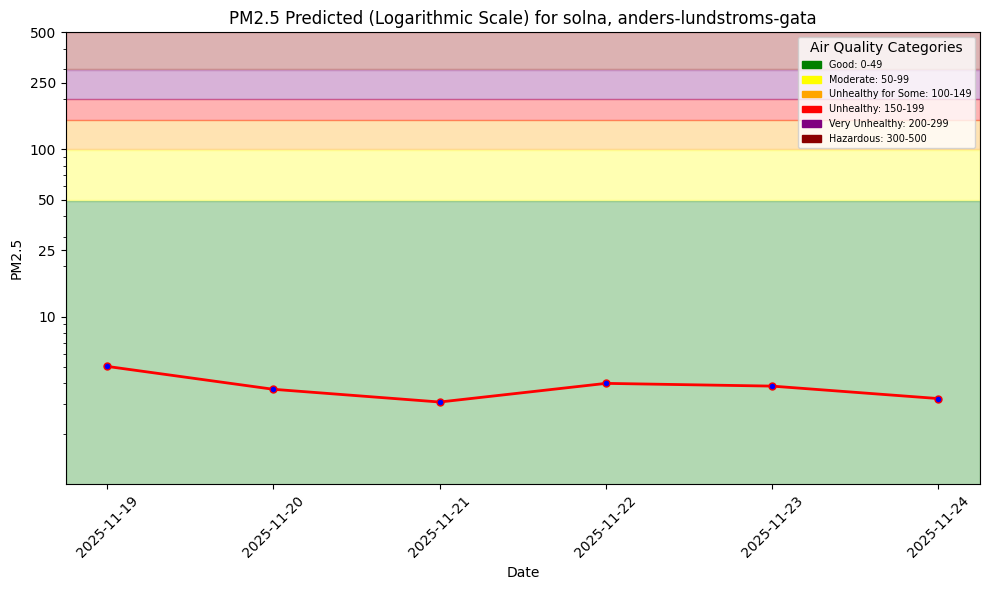

In [21]:
if running_e or running_c:
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

    plt.show()

if running_a:
    for batch_df in batch_data_frames:
        street = batch_df['street'][0]
        pred_file_path = f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_forecast{street}.png"
        plt = util.plot_air_quality_forecast(city, street, batch_df, pred_file_path)

        plt.show()

In [22]:
# Get or create feature group

#Select version of feature group
if running_e:
    m_version = 1

if running_c:
    m_version = 2

if running_a:
    m_version = 3

monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=m_version,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [23]:
if running_e or running_c:
    monitor_fg.insert(batch_data, wait=True)

if running_a:
    all_data_frames = None
    for frame in batch_data_frames:
        if all_data_frames is None:
            all_data_frames = frame
        else:
            all_data_frames = pd.concat([all_data_frames,frame], ignore_index=True)
    monitor_fg.insert(all_data_frames, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-18 18:22:24,018 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 18:22:30,520 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:23:44,739 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 18:23:54,417 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-18 18:23:54,900 INFO: Waiting for log aggregation to finish.
2025-11-18 18:23:54,900 INFO: Execution finished successfully.


In [24]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,3.100000,0.0,11.525623,284.470337,solna,3.00,3.00,2.00,2.150167,anders-lundstroms-gata,sweden,1
1,2025-11-10 00:00:00+00:00,5.476417,0.0,5.762812,12.179147,solna,3.00,2.00,8.52,4.413958,anders-lundstroms-gata,sweden,1
2,2025-11-08 00:00:00+00:00,5.576417,0.0,7.493277,244.666122,solna,8.52,8.64,2.17,9.730795,anders-lundstroms-gata,sweden,1
3,2025-11-05 00:00:00+00:00,11.432667,0.2,18.329092,226.180008,solna,1.15,2.15,2.88,1.447080,anders-lundstroms-gata,sweden,1
4,2025-11-13 00:00:00+00:00,8.750000,0.2,14.277983,303.690094,solna,3.00,2.00,3.00,1.090311,anders-lundstroms-gata,sweden,1
5,2025-11-07 00:00:00+00:00,9.136833,5.2,9.526405,207.367447,solna,8.64,2.17,1.15,16.229687,anders-lundstroms-gata,sweden,1
6,2025-11-11 00:00:00+00:00,5.676417,0.1,9.605998,190.036819,solna,3.00,3.00,2.00,5.803885,anders-lundstroms-gata,sweden,1
7,2025-11-06 00:00:00+00:00,10.870167,1.5,11.638917,234.282501,solna,2.17,1.15,2.15,3.016817,anders-lundstroms-gata,sweden,1
8,2025-11-04 00:00:00+00:00,10.378499,0.7,18.976131,213.386902,solna,2.15,2.88,0.56,2.711536,anders-lundstroms-gata,sweden,1
9,2025-11-12 00:00:00+00:00,7.888916,3.8,27.612844,205.238373,solna,2.00,3.00,3.00,2.868182,anders-lundstroms-gata,sweden,1


In [25]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3
    
air_quality_fg = fs.get_feature_group(name='air_quality', version=aq_version)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,pm25,country,city,street,url,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days
0,2020-07-18 00:00:00+00:00,1.50,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,1.20,1.25,1.70
1,2022-02-12 00:00:00+00:00,1.50,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,0.87,1.30,1.33
2,2022-09-04 00:00:00+00:00,0.77,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,0.75,0.50,0.56
3,2023-11-28 00:00:00+00:00,2.00,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,1.80,0.90,0.83
4,2021-07-03 00:00:00+00:00,3.13,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,2.60,1.65,4.88
...,...,...,...,...,...,...,...,...,...
2148,2025-11-14 00:00:00+00:00,4.00,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,3.00,3.00,2.00
2149,2025-11-15 00:00:00+00:00,4.00,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,4.00,3.00,3.00
2150,2025-11-16 00:00:00+00:00,15.00,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,4.00,4.00,3.00
2151,2025-11-17 00:00:00+00:00,4.00,sweden,solna,anders-lundstroms-gata,https://api.waqi.info/feed/A61420,15.00,4.00,4.00


In [26]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    all_features_df = pd.merge(air_quality_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days', 'date']], features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'date', 'city']])
    all_features_df = all_features_df.sort_values(by=['date'], ascending=True)
    all_features_df = all_features_df.tail(10)

    if running_c:
    
        all_features_df['predicted_pm25'] = model.predict(all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])
        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    if running_a:
        street = air_quality_df.iloc[0]['street']
        all_features_df.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

        all_features_df['predicted_pm25'] = model[street].predict(
            all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])

        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    return hindcast_df
    



In [28]:


if running_e or running_c:
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df

if running_a:
    outcome_df = air_quality_df[['date', 'pm25', 'street']]
    preds_df =  monitoring_df[['date', 'predicted_pm25', 'street']]

    hindcast_df = pd.merge(preds_df, outcome_df, on=['date', 'street'])    
    
    hindcast_dfs = []
    for location in locations:
        sensor_hindcast_df = hindcast_df[hindcast_df['street'] == location['street']]
        sensor_aq_df = air_quality_df[air_quality_df['street'] == location['street']]
        
        sensor_hindcast_df = sensor_hindcast_df.sort_values(by=['date'])

        # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
        if len(sensor_hindcast_df) == 0:
            sensor_hindcast_df = backfill_predictions_for_monitoring(weather_fg, sensor_aq_df, monitor_fg, models)
        
        hindcast_dfs.append(sensor_hindcast_df)

#hindcast_dfs[1]

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

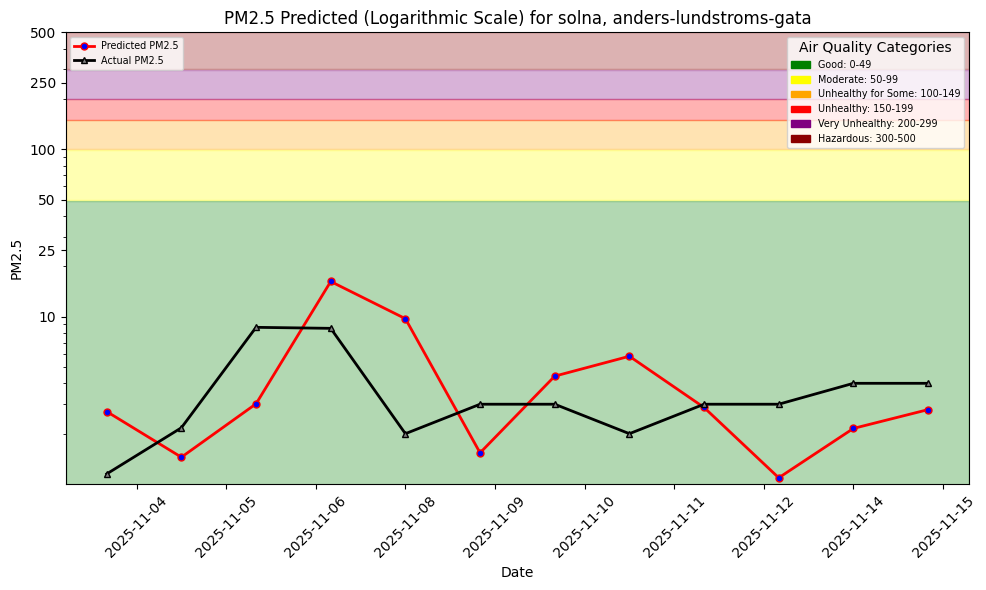

In [29]:
if running_e or running_c:
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

if running_a:
    for h_df in hindcast_dfs:
        street = h_df.iloc[0]['street']
        hindcast_file_path = f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_hindcast_1day{street}.png"
        plt = util.plot_air_quality_forecast(city, street, h_df, hindcast_file_path, hindcast=True)
        plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [30]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

if running_e or running_c:
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

if running_a:
    for location in locations:
        street = location['street']
        dataset_api.upload(f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_forecast{street}.png", f"Resources/air_quality_a_{street}/{city}_{street}_{str_today}", overwrite=True)
        dataset_api.upload(f"{root_dir}/docs/air-quality/air_quality_a_{street}/assets/img/pm25_hindcast_1day{street}.png", f"Resources/air_quality_a_{street}/{city}_{street}_{str_today}", overwrite=True)


proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/asset…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality/asset…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272015/settings/fb/path/Resources/airquality


---